# Exploracion de datos 

# Importacion de datos desde API
No requiere credenciales

In [37]:
from typing import Final
import requests
import zipfile
import io
import pandas as pd
import os
import logging
import warnings
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

DATA_DIR: Final = os.path.join(
    os.path.dirname(os.getcwd()),
    'data',
    'raw'
)

file_path = os.path.join(DATA_DIR, 'online_retail_II.xlsx')

if not os.path.exists(file_path):
    url = "https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip"
    response = requests.request("GET", url)
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))
    zip_file.extractall(path=DATA_DIR)
    logging.info("Downloaded and extracted the zip file")

# Load the .xlsx file into a pandas dataframe
year_2009_2010 = pd.read_excel(file_path, sheet_name='Year 2009-2010')
year_2010_2011 = pd.read_excel(file_path, sheet_name='Year 2010-2011')
logging.info("Loaded the data into a pandas dataframe")

df = pd.concat([year_2009_2010, year_2010_2011], ignore_index=True)
df.head(1)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom


Observamos los tipos de datos disponibles

In [38]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [39]:
df.shape

(1067371, 8)

In [40]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

# Descripción de las variables

In [41]:
# estadísticas de las columnas categoricas
df.describe( include=['object', 'string'])

,Invoice,StockCode,Description,Country
count,1067371,1067371,1062989,1067371
unique,53628,5305,5698,43
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1350,5829,5918,981330


Podemos ver que en el campo Description tenemos valores nulos a analizar. El país con mayores ventas es United Kingdom, tenemos 40 países. El Invoice es el indicador de factura, en realidad en todo el dataset se realizaron 28816 ventas facturadas. 

In [42]:
df.describe( include=['float64', 'int64'])

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


En la variable Quantity hay valores fuera de serie grandes, los datos se concentran en valores cercanos a 10, por lo que existe un sesgo a la derecha, es decir los valores tienen una asímetría positiva. Por ende, los datos deben ser escalados o aplicados con un logaritmo en caso de aplicar modelos estadísticos con supuestos en distribuciones normales. El precio presenta el mismo problema de asimetría positiva. Para el Customer se debe cambiar de número a objeto ya que nos interesa la cantidad que veces que compró un mismo cliente, no operaciones entre el ID. 

In [43]:
df.describe( include= 'datetime64[ns]')

,InvoiceDate
count,1067371
mean,2011-01-02 21:13:55.394028544
min,2009-12-01 07:45:00
25%,2010-07-09 09:46:00
50%,2010-12-07 15:28:00
75%,2011-07-22 10:23:00
max,2011-12-09 12:50:00


En cuanto al tiempo, el rango o periodo es desde 2009 diciembre hasta 2011 diciembre, abarcando un dos años de ventas online. 

# Analisis de valores faltantes

Lo que realizaremos es un analisis de los valores faltantes para descartar cualquier valor nulo por error de digitación. Para ello, compararemos por StockCode para ver si en el periodo de estudio existe un misdo StockCode con el valor que podría ir en los valores faltantes. 

In [44]:
# Step 1: Filter rows where Description or CustomerID is missing
missing_values_df = df[df['Description'].isna() | df['Customer ID'].isna()]

# Step 2: Group by Stockcode or InvoiceID
grouped_by_stockcode = missing_values_df.groupby('StockCode')

# Stockcode example
inconsistent_stockcode = grouped_by_stockcode.apply(
    lambda x: x[['Description', 'Customer ID']].isna().all(axis=0)
).reset_index()

# Filtering the inconsistent groups where not all values are missing
inconsistent_stockcodes = inconsistent_stockcode[inconsistent_stockcode.any(axis=1)]

In [45]:
# no siempre son valores nulos estos codigos:
inconsistent_stockcodes.loc[inconsistent_stockcodes.Description == False]

,StockCode,Description,Customer ID
0,10002,False,True
1,10080,False,True
3,10120,False,True
4,10125,False,True
5,10133,False,True
...,...,...,...
5170,gift_0001_40,False,True
5171,gift_0001_50,False,True
5173,gift_0001_70,False,True
5174,gift_0001_80,False,True


Como ejemplo, veamos gift_0001_80 de codigo de Stock, este tiene dos valores posibles como vemos a continuación:

In [46]:
df.loc[df['StockCode'] == 'gift_0001_80'].Description.unique() 

array([nan, 'Dotcomgiftshop Gift Voucher £80.00'], dtype=object)

Como vimos, hay valores que tienen dos opciones o hasta 3. Por ahora vamos a cambiar los valores de nan por el valor que se utiliza en la serie:

In [47]:
# Step 1: Group by StockCode and get unique values in Description
unique_values = df.groupby('StockCode')['Description'].unique()

# Step 2: Identify StockCodes with exactly one non-null and one NaN value
stockcodes_to_impute = unique_values[unique_values.apply(lambda x: len(x) == 2 and pd.isna(x).any())]

# Step 3: Create a dictionary for imputation (mapping StockCode to its non-null Description)
imputation_dict = {stockcode: next(val for val in values if pd.notna(val)) 
                   for stockcode, values in stockcodes_to_impute.items()}


Acá vemos una lista de los códgios de Stock y su respectivo valor no nulo

In [48]:
imputation_dict

{10002: 'INFLATABLE POLITICAL GLOBE ',
 10109: 'BENDY COLOUR PENCILS',
 10134: 'COLOURING PENCILS BROWN TUBE',
 10138: 'ASSORTED COLOUR JUMBO PEN',
 15030: 'FAN BLACK FRAME ',
 15036: 'ASSORTED COLOURS SILK FAN',
 16010: 'FOLDING CAMPING SCISSOR W/KNIF & S',
 16015: 'MEDIUM CHINESE STYLE SCISSOR',
 16033: 'MINI HIGHLIGHTER PENS',
 16043: 'POP ART PUSH DOWN RUBBER ',
 16044: 'POP-ART FLUORESCENT PENS',
 16046: 'TEATIME PEN CASE & PENS',
 16047: 'POP ART PEN CASE & PENS',
 16049: 'TEATIME GEL PENS ASST',
 16050: 'TEATIME PENCIL WITH RUBBER',
 16051: 'TEATIME PENCIL W STAMP ASST',
 16052: 'TEATIME PUSH DOWN RUBBER',
 16053: 'POPART COL BALLPOINT PEN ASST',
 16119: 'FUNKY GIRL ADDRESS BOOK',
 16192: 'PINK BALLET OPENING CUBE BOX ',
 16212: 'FUNKY GIRLZ ASST MAGNETIC MEMO PAD',
 16215: 'FUNKY GIRLZ MAGNETIC TO DO LIST ',
 16239: 'BALLERINA HEART DECORATION.',
 16254: 'TRANSPARENT ACRYLIC TAPE DISPENSER',
 16259: 'PIECE OF CAMO STATIONERY SET',
 17001: 'HEAVENS SCENT FRAGRANCE OILS ASSTD',
 

Vamos a proceder a remplazar los valores nulos cuando al descripción es un valor nulo y su codigo está en el diccionario que creamos:

In [49]:
# Step 4: Apply the imputation only for the same StockCode
df['Description'] = df.apply(
    lambda row: imputation_dict[row['StockCode']] 
    if pd.isna(row['Description']) and row['StockCode'] in imputation_dict else row['Description'], axis=1
)

Veamos el mismo ejemplo de antes:

In [50]:
df.loc[df['StockCode'] == 'gift_0001_80'].Description.unique() 

array(['Dotcomgiftshop Gift Voucher £80.00'], dtype=object)

Procedemos a ver los valores nulos nuevamente:

In [51]:
df.isna().sum()

Invoice             0
StockCode           0
Description      1320
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

reducimos los valores nulos de Description de 4382 a 1320 una reducción del 70% aproximadamente con este enfoque.
Ahora veamos los valores faltantes y detectemos cuando estos valores son solamente nulos:

In [52]:
# Step 1: Filter rows where Description or CustomerID is missing
missing_values_df = df[df['Description'].isna() | df['Customer ID'].isna()]

# Step 2: Group by Stockcode or InvoiceID
grouped_by_stockcode = missing_values_df.groupby('StockCode')

# Stockcode example
inconsistent_stockcode = grouped_by_stockcode.apply(
    lambda x: x[['Description', 'Customer ID']].isna().all(axis=0)
).reset_index()

# Filtering the inconsistent groups where not all values are missing
inconsistent_stockcodes = inconsistent_stockcode[inconsistent_stockcode.any(axis=1)]



In [53]:
# no siempre son valores nulos estos codigos:
inconsistent_stockcodes.loc[inconsistent_stockcodes.Description == True]

,StockCode,Description,Customer ID
35,16131,True,True
36,16132,True,True
38,16195,True,True
39,16210,True,True
51,16240,True,True
...,...,...,...
5156,DCGSLBOY,True,True
5157,DCGSLGIRL,True,True
5161,GIFT,True,True
5172,gift_0001_60,True,True


In [54]:
df.loc[df['StockCode'] == 'gift_0001_60'].Description.unique() 

array([nan], dtype=object)

Como vemos, tenemos 361 casos en donde el valor de Descripcion siempre es nulo. Ahora para analizar como la eliminación de estos valores afectaría un modelo predictivo: 

In [55]:
# agrupamos por StockCode
grouped_by_stockcode = df.groupby('StockCode')
stockcodes_with_nan = grouped_by_stockcode.apply(lambda x: x['Description'].isna().all())
stockcodes_with_nan = stockcodes_with_nan[stockcodes_with_nan].index.tolist()

In [56]:
stockcodes_with_nan
# un vistazo de los StockCode que siempre son nulos en descripcion

[16131,
 16132,
 16195,
 16210,
 16240,
 16255,
 17017,
 17120,
 17160,
 18033,
 20690,
 20691,
 20710,
 20720,
 20743,
 20824,
 20844,
 20859,
 20880,
 20883,
 20900,
 20904,
 20911,
 20937,
 20938,
 20944,
 20946,
 20951,
 20955,
 20959,
 20965,
 20995,
 21005,
 21019,
 21020,
 21021,
 21022,
 21023,
 21024,
 21029,
 21047,
 21048,
 21052,
 21057,
 21083,
 21104,
 21113,
 21148,
 21170,
 21176,
 21177,
 21182,
 21183,
 21227,
 21236,
 21273,
 21295,
 21301,
 21325,
 21342,
 21345,
 21362,
 21487,
 21492,
 21502,
 21505,
 21510,
 21512,
 21514,
 21583,
 21601,
 21602,
 21646,
 21753,
 21776,
 21778,
 21835,
 21855,
 21859,
 21862,
 21863,
 21909,
 21920,
 22022,
 22213,
 35232,
 35442,
 35473,
 35763,
 35794,
 35839,
 35900,
 35925,
 35926,
 35935,
 35940,
 35941,
 35948,
 35949,
 35960,
 35983,
 35990,
 35992,
 35993,
 35994,
 37350,
 37353,
 37504,
 44276,
 47009,
 47361,
 47559,
 47565,
 48169,
 48172,
 71265,
 71431,
 72234,
 72483,
 72719,
 72748,
 72768,
 72777,
 72778,
 72806,


Podemos ver un resumen estadistico de los valores que siempre son nulos en StockCode:

In [57]:
df.loc[df['StockCode'].isin(stockcodes_with_nan)].describe(include=['int64', 'float64'])

,Quantity,Price,Customer ID
count,363.000000,363.0,0.0
mean,-44.201102,0.0,NaN
std,327.616760,0.0,NaN
min,-4999.000000,0.0,NaN
25%,-23.000000,0.0,NaN
50%,-7.000000,0.0,NaN
75%,-1.000000,0.0,NaN
max,160.000000,0.0,NaN


Con esto vemos que también son siempre nulos los valores de Customer ID, el precio es 0 siempre y las cantidades son negativas o con un maximo de 160 cantidades, concentrandoce en -44 los datos, pero tenemos una asímetría positiva en los datos, es decir hay valores muy negativos que afectan el calculo llegando hasta -5000 aproximadamente. 


Por lo anterior, podemos eliminar los valores nulos, abajo dejo una grafica donde muestro que con esto se afecta únicamente los valores de reino unido. 

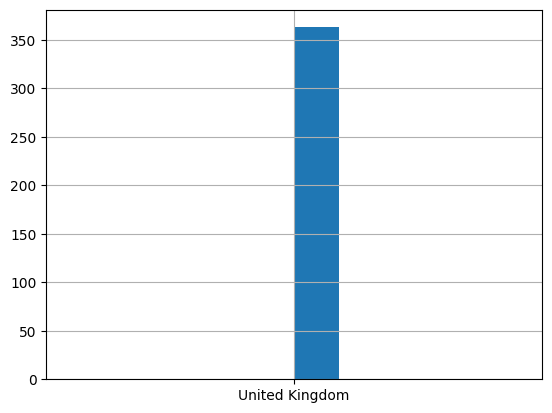

In [58]:
df.loc[df['StockCode'].isin(stockcodes_with_nan)]['Country'].hist()
plt.show()

In [59]:
df = df[~df['StockCode'].isin(stockcodes_with_nan)]

In [60]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,1.067008e+06,1067008,1.067008e+06,824364.000000
mean,9.957317e+00,2011-01-02 23:50:41.346493696,4.650969e+00,15324.638504
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000
25%,1.000000e+00,2010-07-09 11:44:00,1.250000e+00,13975.000000
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000
75%,1.000000e+01,2011-07-22 10:52:00,4.150000e+00,16797.000000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000
std,1.726268e+02,NaN,1.235740e+02,1697.464450


Revisando la columman Invoide date de hallas fechas incorresta 

In [61]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

# Ingeneria de Caracteristicas



In [70]:
# Extraer el año
df['Year'] = df['InvoiceDate'].dt.year
# Extraer el mes
df['Month'] = df['InvoiceDate'].dt.month
# Extraer el día
df['Day'] = df['InvoiceDate'].dt.day
# Extraer Hora
df['Hour'] = pd.to_datetime(df['InvoiceDate']).dt.hour
# Extraer dia de la Semana
df['DayOfWeek'] = pd.to_datetime(df['InvoiceDate']).dt.dayofweek
# Extraer si es fecha fin de semana
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6])
# Colummna Ganacia
df["Ganacia"]= df["Price"]*df["Quantity"]

# Extraer estacionalidad  

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

# Frecuencia de compras del Cliente

df['PurchaseFrequency'] = df.groupby('Customer ID')['Invoice'].transform('count')

# Valor total del Cliente

df['CustomerLifetimeValue'] = df.groupby('Customer ID')['Ganacia'].transform('sum')

# Total de productos comprados

df['TotalQuantity'] = df.groupby('Invoice')['Quantity'].transform('sum')

# Precio Promedio de transaccion 
df['AvgPricePerTransaction'] = df.groupby('Invoice')['Price'].transform('mean')

# Identificación de transacciones atípicas
df['IsAnomalous'] = (df['Quantity'] > df['Quantity'].quantile(0.99)) | (df['Price'] > df['Price'].quantile(0.99))

# Valor total de la factura
df['TotalInvoiceValue'] = df['Quantity'] * df['Price']

# Ganancia total por cliente y mes
df['CustomerMonthlyGain'] = df.groupby(['Customer ID', 'Year', 'Month'])['Ganacia'].transform('sum')



In [73]:
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,Month,...,DayOfWeek,IsWeekend,Season,PurchaseFrequency,CustomerLifetimeValue,TotalQuantity,AvgPricePerTransaction,IsAnomalous,TotalInvoiceValue,CustomerMonthlyGain
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,12,...,1,False,Winter,92.0,1459.46,166,4.08125,False,83.4,1096.8
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,...,1,False,Winter,92.0,1459.46,166,4.08125,False,81.0,1096.8
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,...,1,False,Winter,92.0,1459.46,166,4.08125,False,81.0,1096.8
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,12,...,1,False,Winter,92.0,1459.46,166,4.08125,False,100.8,1096.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,12,...,1,False,Winter,92.0,1459.46,166,4.08125,False,30.0,1096.8


In [72]:
df.shape
print(f"El nuevo dataframe luego de la implementacion de extraccion y enriquecimiento de caractersticas es {df.shape}")

El nuevo dataframe luego de la implementacion de extraccion y enriquecimiento de caractersticas es (1067008, 23)


In [75]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID,Year,Month,Day,Ganacia,Hour,DayOfWeek,PurchaseFrequency,CustomerLifetimeValue,TotalQuantity,AvgPricePerTransaction,TotalInvoiceValue,CustomerMonthlyGain
count,1.067008e+06,1067008,1.067008e+06,824364.000000,1.067008e+06,1.067008e+06,1.067008e+06,1.067008e+06,1.067008e+06,1.067008e+06,824364.000000,824364.000000,1.067008e+06,1.067008e+06,1.067008e+06,824364.000000
mean,9.957317e+00,2011-01-02 23:50:41.346493696,4.650969e+00,15324.638504,2.010426e+03,7.498006e+00,1.513542e+01,1.807601e+01,1.303347e+01,2.463063e+00,1071.122215,20132.988178,5.114944e+02,4.650969e+00,1.807601e+01,1572.132246
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000,2.009000e+03,1.000000e+00,1.000000e+00,-1.684696e+05,6.000000e+00,0.000000e+00,1.000000,-25111.090000,-8.716700e+04,-5.359436e+04,-1.684696e+05,-25111.090000
25%,1.000000e+00,2010-07-09 11:44:00,1.250000e+00,13975.000000,2.010000e+03,5.000000e+00,8.000000e+00,3.750000e+00,1.100000e+01,1.000000e+00,147.000000,1746.640000,1.410000e+02,2.269630e+00,3.750000e+00,322.650000
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000,2.010000e+03,8.000000e+00,1.500000e+01,9.900000e+00,1.300000e+01,2.000000e+00,353.000000,4459.830000,2.820000e+02,3.078882e+00,9.900000e+00,585.550000
75%,1.000000e+01,2011-07-22 10:52:00,4.150000e+00,16797.000000,2.011000e+03,1.100000e+01,2.200000e+01,1.770000e+01,1.500000e+01,4.000000e+00,814.000000,11143.990000,5.270000e+02,4.743250e+00,1.770000e+01,1130.740000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000,2.011000e+03,1.200000e+01,3.100000e+01,1.684696e+05,2.100000e+01,6.000000e+00,13097.000000,598215.220000,8.716700e+04,3.897000e+04,1.684696e+05,70246.500000
std,1.726268e+02,NaN,1.235740e+02,1697.464450,5.737146e-01,3.525664e+00,8.680376e+00,2.924698e+02,2.435354e+00,1.880605e+00,2311.218994,59042.779410,1.450802e+03,1.226769e+02,2.924698e+02,3816.375857


In [69]:
ventas_por_año = df.groupby('Year').agg({'Price': 'sum'}).reset_index()
print(ventas_por_año)

   Year        Price
0  2009   198307.760
1  2010  2526012.744
2  2011  2238301.124
